**Title:** "Convert Bathymetry Elevation  
**Author:** J. Daniel Vélez (based on NXSDB demo)  
**Date:** 06/03/2025

In [34]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import dataretrieval.nwis as nwis
import dataretrieval as dr
from IPython.display import display, HTML
import os
import base64
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import help_fxs as helpfxs

In [2]:
os.chdir("../0_data/External/Bathymetries/namerica/Ohio/NXSDB") # Uncomment to change to the directory where the data is stored
os.getcwd()

'/Users/josele/Library/CloudStorage/GoogleDrive-ejdvc757@gmail.com/Other computers/My MacBook Pro/PhD/Dissertation/0_data/External/Bathymetries/namerica/Ohio/NXSDB'

In [3]:
station_master_pth = "./NXSDB_WY2022_CONUS_station_master.txt"
station_master = pd.read_csv(station_master_pth, sep="\t", dtype={"station": str})

In [4]:
# Path to GPKG file
gpkg_pth = "./NXSDB_WY2022_CONUS.gpkg"
schema_path = "./NXSDB_schema_v1.0.0.json"

# The read_gpkg() function takes the path tho the GeoPackage, a single layer name or list of layer names, ant the path to the schema file
#gpkg_geom = helpfxs.read_gpkg(gpkg_pth, "geometry", schema_path)

In [16]:
## Function select data for a given river
def river_data(river_name):
    river_selected = station_master[station_master["station_nm"].str.contains(river_name)]

    # Convert station IDs to strings
    station_ids_str = river_selected["station"].astype(str).tolist()

    #define the number of chuncks
    n_chunks = 1

    # Split the list into smaller chunks
    split_list = np.array_split(station_ids_str, n_chunks)
    data_list = [] # List to store results

    for site_list in split_list:

        # Get discharge measurements for the current chunk
        data_chunk = nwis.get_discharge_measurements(sites=site_list.tolist(), start='2021-10-01', end='2022-09-30')[0]
        data_list.append(data_chunk) # append the data to the list

    # Combine all the data chunks into a single dataframe
    nwis_mmts = pd.concat(data_list, ignore_index=True)

    # Querying the database
    gpkg_geom = helpfxs.read_gpkg(gpkg_pth, "geometry", schema_path)
    gpkg_geom_georef = gpkg_geom[gpkg_geom['station_nm'].str.contains(river_name)]
    station_list = gpkg_geom_georef.station
    print(f"After subsetting, there are {len(station_list)} stations In the {river_name}")
    return nwis_mmts, gpkg_geom_georef, station_list

In [17]:
river_name = "OHIO RIVER"
nwis_result, river_gpkg, station_list = river_data(river_name)

After subsetting, there are 10 stations In the OHIO RIVER


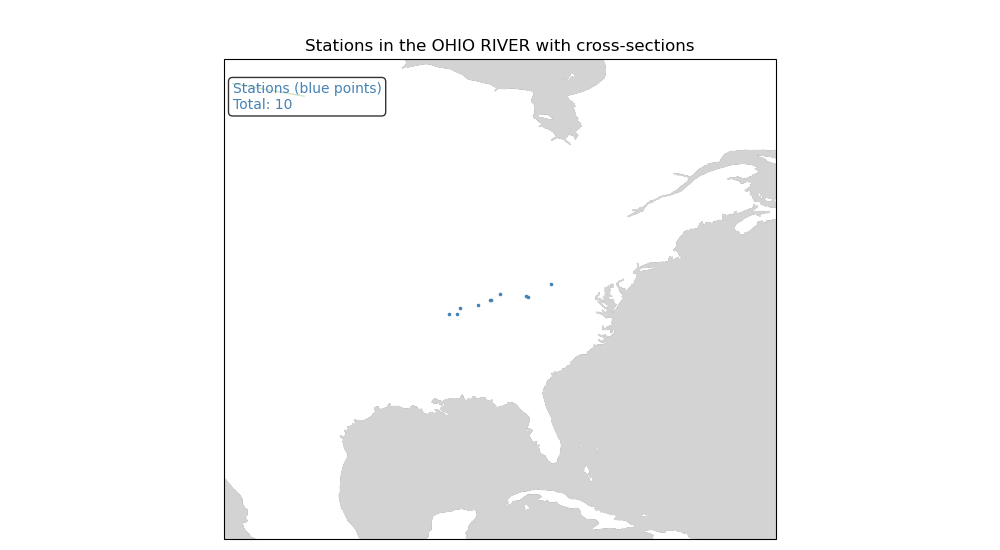

In [15]:
helpfxs.plot_gpkg(river_gpkg, title=f"Stations in the {river_name} with cross-sections", legend="Stations", fig=[10,5.5],buffer_degrees=18.0)

In [19]:
stations_w_georeferenced_mmts = station_list + "_record"
georeferenced_records = helpfxs.read_gpkg(gpkg_pth, stations_w_georeferenced_mmts, schema_path)

# Show first two record layers in the dictionary
dict(list(georeferenced_records.items()))

{'03294500_record':    fid                  mmt_ID              mmt_Timestamp CrossSectionType  \
 0    1  03294500_mb_20220502_1  2022-05-02T14:15:59-05:00               mb   
 1    2  03294500_mb_20220712_1  2022-07-12T13:35:15-05:00               mb   
 2    3  03294500_mb_20220927_1  2022-09-27T09:57:48-05:00               mb   
 
   Georeferenced MeasurementQualityCode ChannelNumber  ChannelArea  \
 0         false                   FAIR             1    33734.973   
 1          true                   FAIR             1    25669.585   
 2         false                   FAIR             1    26783.016   
 
   ChannelArea_units  ChannelWidth  ... ChannelEvennessCode  \
 0                sf      1691.437  ...                EVEN   
 1                sf      1639.597  ...                UNSP   
 2                sf      1595.930  ...                EVEN   
 
   DeploymentMethodCode SectionLocationCode SectionDistanceMeasure  \
 0                 MBOT                DNST              

In [20]:
georeferenced_records[list(georeferenced_records.keys())[0]]

,fid,mmt_ID,mmt_Timestamp,CrossSectionType,Georeferenced,MeasurementQualityCode,ChannelNumber,ChannelArea,ChannelArea_units,ChannelWidth,...,ChannelEvennessCode,DeploymentMethodCode,SectionLocationCode,SectionDistanceMeasure,SectionDistanceMeasure_units,SoftwareVersionText,MovingBedEffected,CrossSectionColumns,GageHeight_ft,Discharge_cfs
0,1,03294500_mb_20220502_1,2022-05-02T14:15:59-05:00,mb,false,FAIR,1,33734.973,sf,1691.437,...,EVEN,MBOT,DNST,1000.0,ft,QRev 4.29,false,"Distance_Meters, Distance_X_Meters, Distance_Y...",19.41,110000
1,2,03294500_mb_20220712_1,2022-07-12T13:35:15-05:00,mb,true,FAIR,1,25669.585,sf,1639.597,...,UNSP,MBOT,DNST,4000.0,ft,QRev 4.31,false,"Latitude_Degrees, Longitude_Degrees, Distance_...",15.10,69400
2,3,03294500_mb_20220927_1,2022-09-27T09:57:48-05:00,mb,false,FAIR,1,26783.016,sf,1595.930,...,EVEN,MBOT,DNST,61500.0,ft,QRev 4.32,false,"Distance_Meters, Distance_X_Meters, Distance_Y...",11.15,26500


In [25]:
# Initialize an empty list to store the extracted mmt_id values
georeferenced_mmt_IDs = []

# Iterate through each DataFrame in the dictionary
for df in georeferenced_records.values():
    # Extract the mmt_id values where Georeferenced is true
    mmt_IDs = df.loc[df['Georeferenced'] == "true", 'mmt_ID'].tolist()
    # Append the extrtacted mmt_id values to the list
    georeferenced_mmt_IDs.extend(mmt_IDs)

# First 10 measurements IDs (or less)
print (georeferenced_mmt_IDs[:10])
print(f"Now there are {len(georeferenced_mmt_IDs)} georeferenced cross-sections for gages referenced to NAVD88. Notice how they are all moving-boat ADCP measurements as indicated by the 'mb' string in the mmt_ID. Let's look at the data.")

['03294500_mb_20220712_1', '03292494_mb_20220310_1', '03303280_mb_20220308_1', '03216070_mb_20220215_1', '03277200_mb_20220505_1', '03381700_mb_20220427_1']
Now there are 6 georeferenced cross-sections for gages referenced to NAVD88. Notice how they are all moving-boat ADCP measurements as indicated by the 'mb' string in the mmt_ID. Let's look at the data.


In [26]:
georeferenced_xs = helpfxs.read_gpkg(gpkg_pth, georeferenced_mmt_IDs, schema_path)

#Show the first two records in the dictionary
dict(list(georeferenced_xs.items())[:])

{'03294500_mb_20220712_1':        fid  Latitude_Degrees  Longitude_Degrees  Distance_Meters  \
 0        1         38.277692         -85.818354           30.617   
 1        2         38.277694         -85.818355           30.818   
 2        3         38.277695         -85.818356           31.019   
 3        4         38.277697         -85.818357           31.220   
 4        5         38.277699         -85.818358           31.421   
 ...    ...               ...                ...              ...   
 2307  2308         38.281591         -85.820671          494.016   
 2308  2309         38.281593         -85.820672          494.217   
 2309  2310         38.281594         -85.820673          494.418   
 2310  2311         38.281596         -85.820674          494.619   
 2311  2312         38.281598         -85.820675          494.820   
 
       Distance_X_Meters  Distance_Y_Meters  Depth_Meters  
 0                   NaN                NaN           NaN  
 1               -30.726

In [28]:
# Initialize a dictionary to store individual GeoDataFrames
gdf_dict = {}

# Iterate through each DatFrame in the dictionary
for key, df in georeferenced_xs.items():
    # Check for NaN values in Latitude or Longitude columns
    if df['Latitude_Degrees'].isna().any() or df['Longitude_Degrees'].isna().any():
        print(f"Skipping{key} due to NaN values in latitude or longitude")
        continue

    # Add the mmt_ID column with the current dictionary key
    df['mmt_ID'] = key
    # Create a geometry column using the Latitude and Longitude columns
    geometry = [Point(xy) for xy in zip(df['Longitude_Degrees'], df['Latitude_Degrees'])]
    # Create the GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    # Set the coordinate references system (CRS) to EPSG:4326 (WGS84
    gdf.set_crs(epsg=4326, inplace=True)
    # Add the GeoDataFrame to the dictionary
    gdf_dict[key] = gdf

print(gdf)

     fid  Latitude_Degrees  Longitude_Degrees  Distance_Meters  \
0      1         37.692445         -88.126313           14.659   
1      2         37.692449         -88.126321           15.522   
2      3         37.692453         -88.126329           16.385   
3      4         37.692458         -88.126337           17.248   
4      5         37.692462         -88.126345           18.110   
..   ...               ...                ...              ...   
873  874         37.696193         -88.133421          767.857   
874  875         37.696198         -88.133430          768.720   
875  876         37.696202         -88.133438          769.583   
876  877         37.696206         -88.133446          770.445   
877  878         37.696210         -88.133454          771.308   

     Distance_X_Meters  Distance_Y_Meters  Depth_Meters  \
0                  NaN                NaN           NaN   
1              -14.527              5.468         4.970   
2              -15.264        

In [30]:
print(gdf_dict['03294500_mb_20220712_1'])

       fid  Latitude_Degrees  Longitude_Degrees  Distance_Meters  \
0        1         38.277692         -85.818354           30.617   
1        2         38.277694         -85.818355           30.818   
2        3         38.277695         -85.818356           31.019   
3        4         38.277697         -85.818357           31.220   
4        5         38.277699         -85.818358           31.421   
...    ...               ...                ...              ...   
2307  2308         38.281591         -85.820671          494.016   
2308  2309         38.281593         -85.820672          494.217   
2309  2310         38.281594         -85.820673          494.418   
2310  2311         38.281596         -85.820674          494.619   
2311  2312         38.281598         -85.820675          494.820   

      Distance_X_Meters  Distance_Y_Meters  Depth_Meters  \
0                   NaN                NaN           NaN   
1               -30.726             -2.380         3.383   
2  

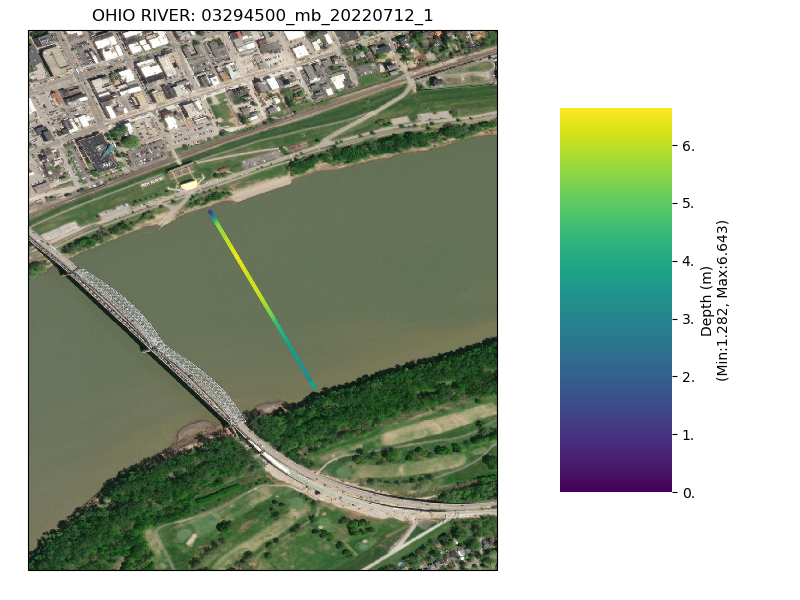

In [32]:
helpfxs.plot_gpkg(gdf_dict['03294500_mb_20220712_1'],
                  basemap="image",
                  plot_col=(0,None,"Depth_Meters"),
                  title = f"{river_name}: 03294500_mb_20220712_1",
                  legend="Depth (m)",
                buffer_degrees=0.004,
                fig=[8,6],
                hist=False)

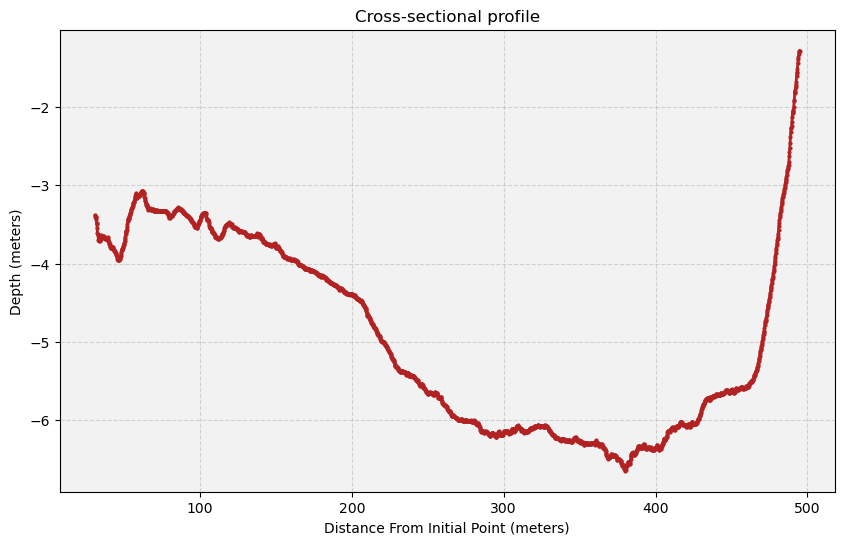

In [33]:
# Iterate over the dictionary and plot each dataframe
plt.figure(figsize=(10, 6))
helpfxs.plot_mb_xs(gdf_dict['03294500_mb_20220712_1'], color='firebrick', units="meters")

**Convert Bathymetry Elevation**

In [74]:
def datum_change(gaugeCode):
    river_gauge = nwis.get_info(sites = gaugeCode)
    # Define the URL to the USGS site
    # params = {"series CatalogOutput": "true",
    # "sites = gaugeCode,
    # "format": "rdb"}
    url = f"https://waterservices.usgs.gov/nwis/site/?seriesCatalogOutput=true&sites={gaugeCode}&format=rdb"

    river_stage, metadata = nwis.get_iv(sites = gaugeCode,
                              parameterCd = "00065",
                              start = "2021-10-01",
                              end = "2025-02-01")
    # Check if river_gauge DataFrame has the 'alt_va' column
    if "alt_va" not in river_gauge.columns:
        raise ValueError(f"'alt_va' not found in metadata for site {gaugeCode}.")

    # Extract first datum value (if available)
    gage_datum_ft = river_gauge["alt_va"].iloc[0]

    # Convert gage height to NAVD88 meters
    river_stage["elevation_NAVD88"] = (river_stage["00065"] * 0.3048) + (gage_datum_ft * 0.3048)

    return river_stage


In [75]:
datum_change("03277200")

AttributeError: 'tuple' object has no attribute 'columns'